<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/homeworks/h2/hw_02.ipynb
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Nicole Gómez

* __Rol__: 201810507-4

2.- Debes _subir_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
   - Soluciones
   - Código
   - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [6]:

from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import warnings
import timeit
import time

warnings.filterwarnings("ignore")

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(20,30)})
%matplotlib inline


In [7]:

digits.describe()


,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


**¿Como se distribuyen los datos?**

65


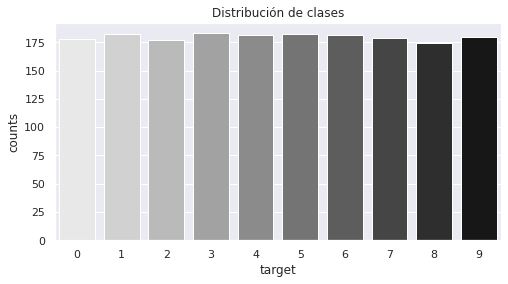

In [35]:

print(len(digits.columns))
gr = digits.groupby(['target']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(8,4),nrows=1)
sns.barplot(data=gr, x='target', y='counts', palette="gray_r",ax=ax)
ax.set_title('Distribución de clases')
plt.show()
print("")

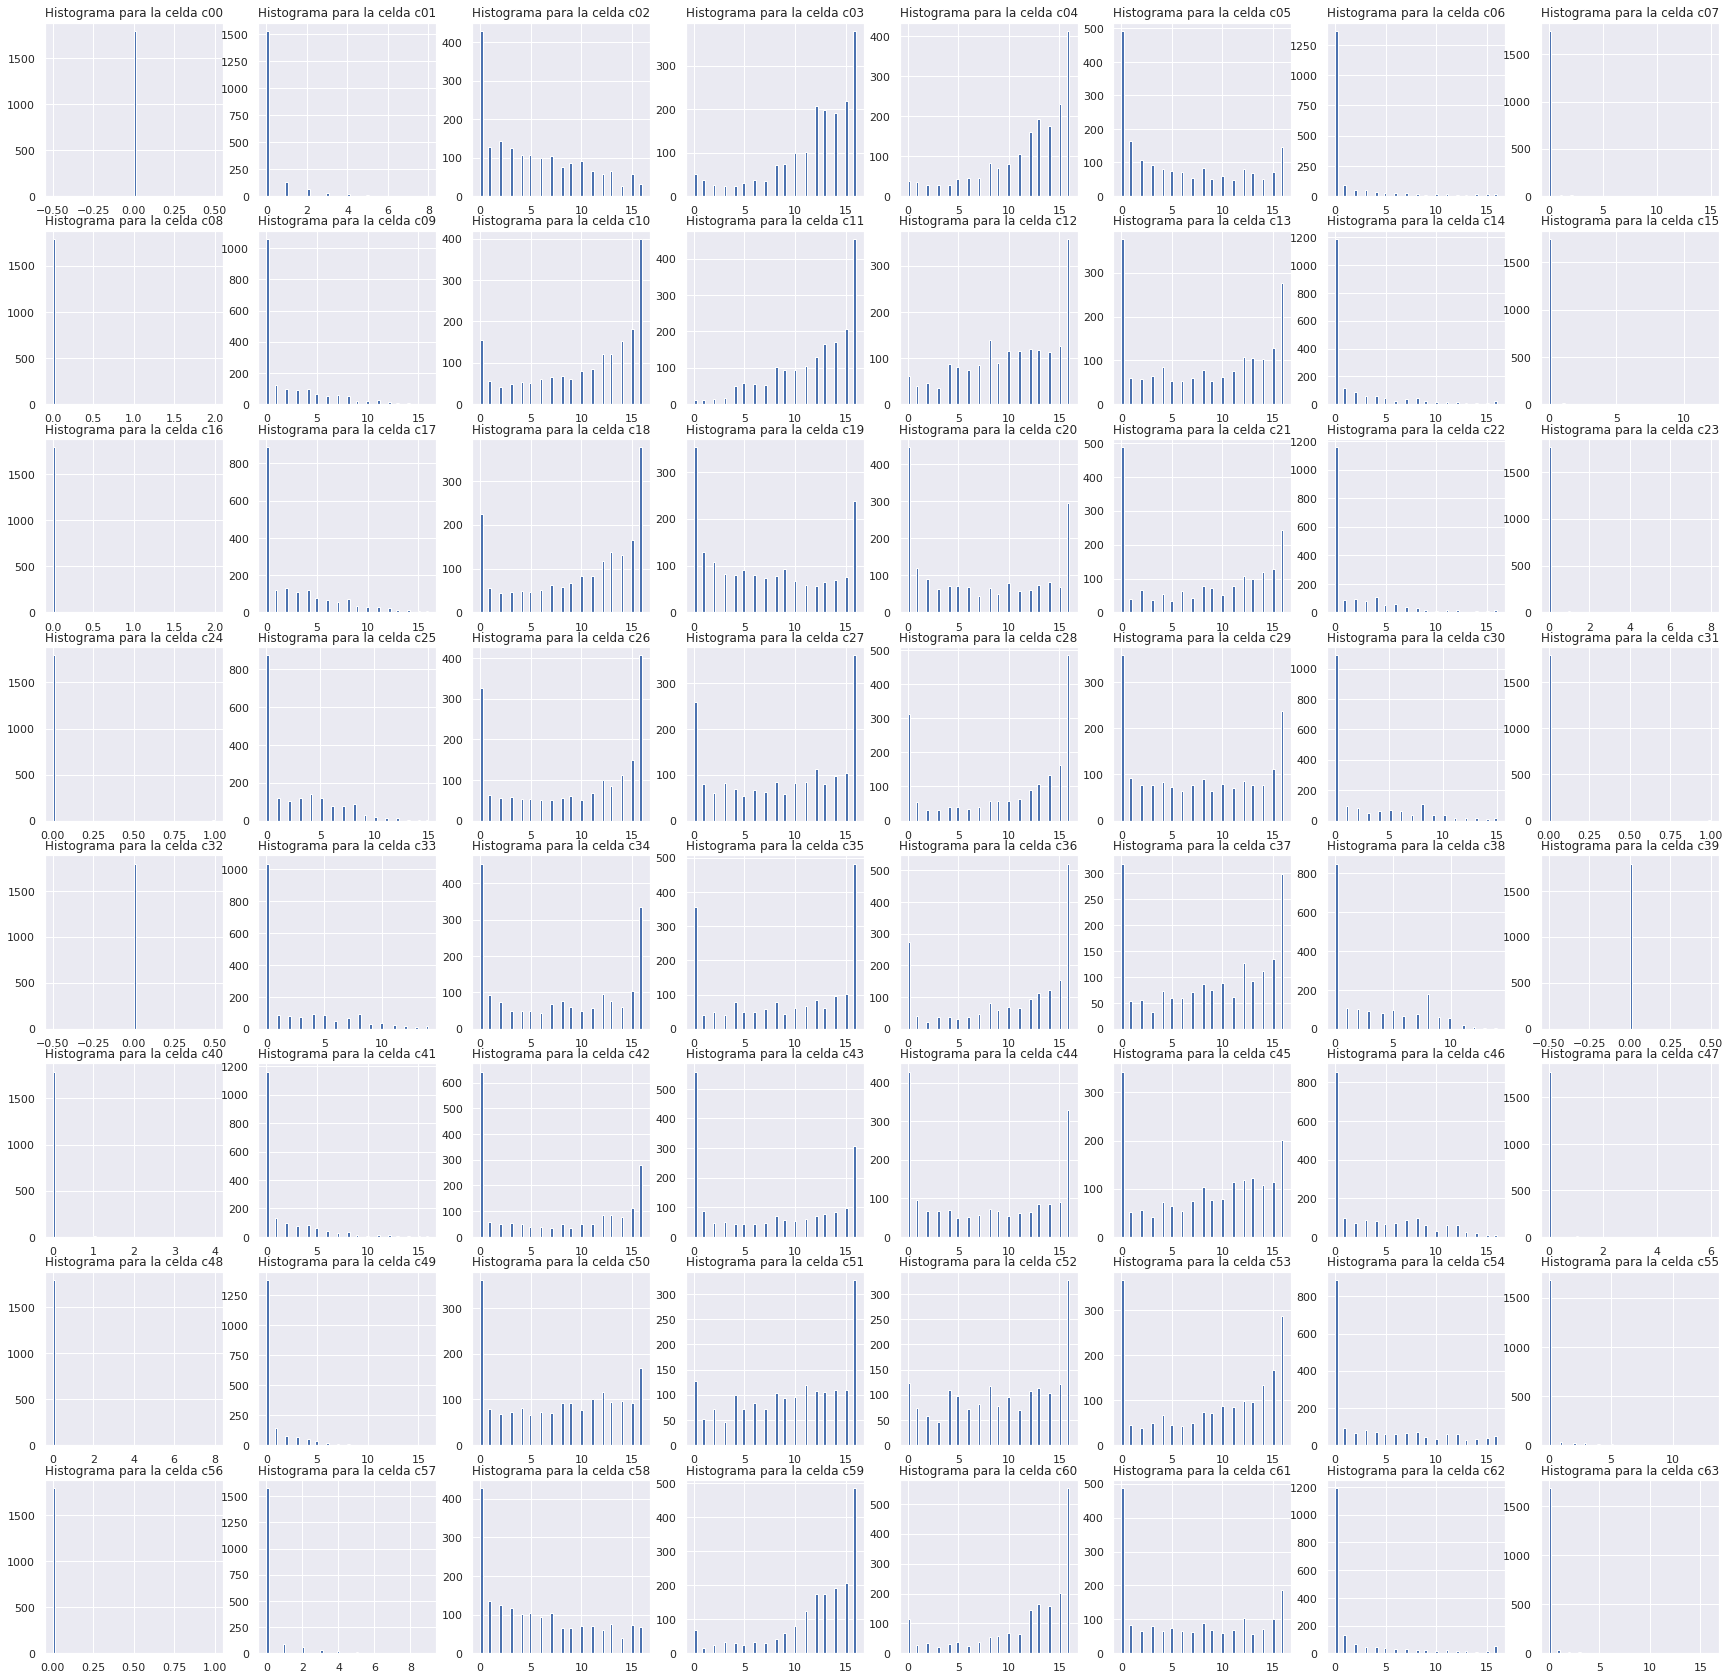

In [9]:

df=digits.drop(['target'],axis=1) #df sin target
figure(num=None, figsize=(30, 30)) 
k=1 
for i in df.columns: #recorrer columnas
    plt.subplot(8,8,k)
    plt.hist(df[i], bins = 60)
    plt.title('Histograma para la celda '+i)
    k+=1

plt.show()

**¿Cuánta memoria estoy utilizando?**

In [10]:

import sys
memoria = digits.memory_usage() 
memoria
total = 0
for i in range(0,len(memoria)):
    total += memoria[i] 
print(total,'bytes')

934568 bytes


**¿Qué tipo de datos son?**

In [11]:
digits.dtypes.unique()

array([dtype('int64')], dtype=object)

**¿Cuántos registros por clases hay?**

In [46]:
df_mask= digits["target"]==0
filtered_df = digits[df_mask]

In [51]:
#clase del 0
filtered_df.shape[0]

178

In [52]:
df_mask= digits["target"]==1
filtered_df1 = digits[df_mask]

In [53]:
#clase del 1
filtered_df1.shape[0]

182

In [54]:
df_mask= digits["target"]==2
filtered_df2 = digits[df_mask]

In [55]:
#clase del 2
filtered_df2.shape[0]

177

In [56]:
df_mask= digits["target"]==3
filtered_df3 = digits[df_mask]

In [57]:
#clase del 3
filtered_df3.shape[0]

183

In [58]:
df_mask= digits["target"]==4
filtered_df4 = digits[df_mask]

In [59]:
#clase del 4
filtered_df4.shape[0]

181

In [60]:
df_mask= digits["target"]==5
filtered_df5 = digits[df_mask]

In [61]:
#clase del 5
filtered_df5.shape[0]

182

In [62]:
df_mask= digits["target"]==6
filtered_df6 = digits[df_mask]

In [63]:
#clase del 6
filtered_df6.shape[0]

181

In [64]:
df_mask= digits["target"]==7
filtered_df7 = digits[df_mask]

In [65]:
#clase del 7
filtered_df7.shape[0]

179

In [66]:
df_mask= digits["target"]==8
filtered_df8 = digits[df_mask]

In [67]:
#clase del 8
filtered_df8.shape[0]

174

In [68]:
df_mask= digits["target"]==9
filtered_df9 = digits[df_mask]

In [69]:
#clase del 9
filtered_df9.shape[0]

180

**¿Hay registros que no correspondan con tu conocimiento previo de los datos?**

In [12]:
digits.describe().T['count'].unique()


array([1797.])

R: No

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [13]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

> **Sugerencia**: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

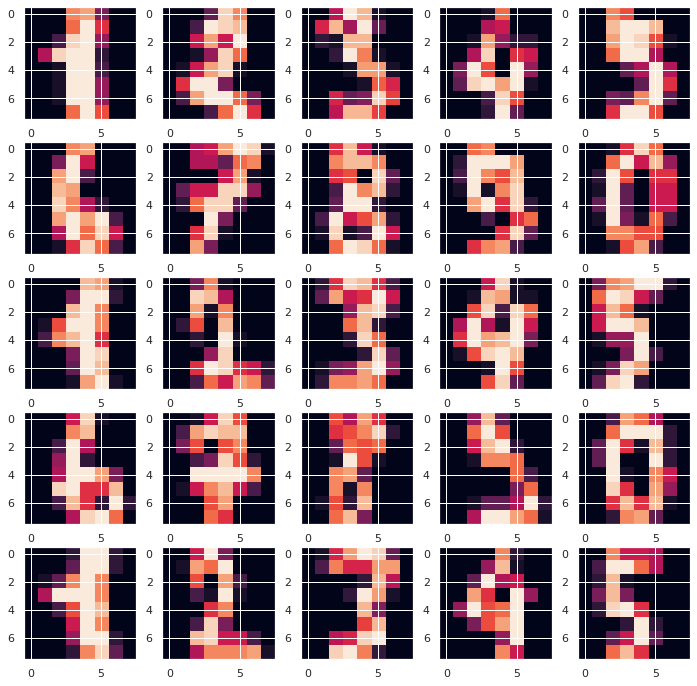

In [14]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(digits_dict["images"][i])


### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [15]:
X = digits.drop(columns="target").values
y = digits["target"].values

#### **1. Train-Test**

In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Largo Train: ", X_train.shape)
print("Largo Test: ", X_test.shape)

Largo Train:  (1437, 64)
Largo Test:  (360, 64)


#### **2. Modelos y métricas**

**KNN**

In [17]:

parameters = {'n_neighbors':[1, 10]}
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.986082 con {'n_neighbors': 1}


In [18]:

#Entrenar modelo
clfknn = KNeighborsClassifier(n_neighbors=1)
clfknn.fit(X_train, y_train)
%timeit clfknn.fit(X_train, y_train)
#Predicción
y_pred= clfknn.predict(X_test)

df_knn = pd.DataFrame({
    'y': y_test,   
    'yhat': y_pred
})

confusion_matrix(y_test, y_pred)

258 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 34,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 28,  1],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  0, 37]])

In [19]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))


              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    0.93333   1.00000   0.96552        28
    numero 2    1.00000   1.00000   1.00000        33
    numero 3    0.97143   1.00000   0.98551        34
    numero 4    0.97826   0.97826   0.97826        46
    numero 5    0.97872   0.97872   0.97872        47
    numero 6    0.97222   1.00000   0.98592        35
    numero 7    1.00000   0.97059   0.98507        34
    numero 8    1.00000   0.93333   0.96552        30
    numero 9    0.94872   0.92500   0.93671        40

    accuracy                        0.97778       360
   macro avg    0.97827   0.97859   0.97812       360
weighted avg    0.97816   0.97778   0.97771       360



**SVM**

In [20]:

from sklearn.svm import SVC
parameters = {'kernel':('linear', 'rbf'), 'C':range(10)}
sv = svm.SVC()
gs = GridSearchCV(sv, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))


Best: 0.991655 con {'C': 7, 'kernel': 'rbf'}


In [21]:
from sklearn.svm import SVC

#Entrenar modelo
clfsvm = SVC(kernel= 'rbf', C=9)
%timeit clfsvm.fit(X_train, y_train)

#Predicción
y_pred= clfsvm.predict(X_test)
df_svm = pd.DataFrame({
    'y': y_test,   
    'yhat': y_pred
})

confusion_matrix(y_test, y_pred)

49.9 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 29,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 39]])

In [22]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    1.00000   1.00000   1.00000        28
    numero 2    1.00000   1.00000   1.00000        33
    numero 3    1.00000   0.97059   0.98507        34
    numero 4    1.00000   1.00000   1.00000        46
    numero 5    0.95833   0.97872   0.96842        47
    numero 6    0.97222   1.00000   0.98592        35
    numero 7    0.97059   0.97059   0.97059        34
    numero 8    1.00000   0.96667   0.98305        30
    numero 9    0.97500   0.97500   0.97500        40

    accuracy                        0.98611       360
   macro avg    0.98761   0.98616   0.98681       360
weighted avg    0.98630   0.98611   0.98613       360



**Regresión logistica**

In [23]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C':[1, 10]}
reg = LogisticRegression()
gs = GridSearchCV(reg, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))


Best: 0.954063 con {'C': 1, 'penalty': 'l2'}


In [24]:

#Entrenar modelo
clflog = LogisticRegression(penalty='l2', C=10)
clflog.fit(X_train, y_train)
%timeit clflog.fit(X_train, y_train)
#Predicción
y_pred= clflog.predict(X_test)

df_log = pd.DataFrame({
    'y': y_test,   
    'yhat': y_pred
})


confusion_matrix(y_test, y_pred)

323 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 44,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 44,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 29,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  1, 37]])

In [25]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))


              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    0.96552   1.00000   0.98246        28
    numero 2    0.97059   1.00000   0.98507        33
    numero 3    0.94286   0.97059   0.95652        34
    numero 4    1.00000   0.95652   0.97778        46
    numero 5    0.91667   0.93617   0.92632        47
    numero 6    0.94444   0.97143   0.95775        35
    numero 7    1.00000   0.97059   0.98507        34
    numero 8    0.96667   0.96667   0.96667        30
    numero 9    0.97368   0.92500   0.94872        40

    accuracy                        0.96667       360
   macro avg    0.96804   0.96970   0.96864       360
weighted avg    0.96724   0.96667   0.96671       360



**¿Cuál modelo es mejor basado en sus métricas?** \\
**R:** El mejor modelo sería SVM \\
**¿Cuál modelo demora menos tiempo en ajustarse?** \\
**R:** El KNN con 0.258 ms \\
**¿Qué modelo escoges?** \\
**R:** escogeria el SVM por las metricas \\





### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

In [26]:

from sklearn.model_selection import cross_val_score
svm_best = svm.SVC(kernel='rbf', C=10)
scores = cross_val_score(svm_best, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.03)


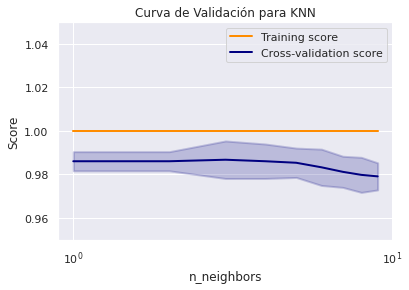

In [70]:
from sklearn.model_selection import validation_curve

param_range = np.array([i for i in range(1,10)])


train_scores, test_scores = validation_curve(
    KNeighborsClassifier(algorithm = 'auto', metric = 'euclidean', weights = 'distance'), #
    X_train,
    y_train,
    param_name="n_neighbors",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=1
)
parameters = {'kernel':['rbf'], 'C': np.arange(1,10)}
svm = SVC()
gs = GridSearchCV(svm, parameters,return_train_score=True)
gs.fit(X_train,y_train)
C_values= np.arange(1,10)
test_accuracy = []
for C_val in C_values:
    svm = SVC(kernel='rbf', C=C_val)
    svm.fit(X_train,y_train)
    test_accuracy.append(svm.score(X_test,y_test))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Curva de Validación para KNN")
plt.xlabel("n_neighbors")
plt.ylabel("Score")

plt.ylim(0.95, 1.05)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

plt.show()

In [72]:

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

y = label_binarize(y, classes=digits["target"].unique())
n_classes = y.shape[1]

n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    train_size = 0.8,
                                                    random_state=1998)

classifier = OneVsRestClassifier(KNeighborsClassifier(algorithm = 'auto', metric = 'euclidean', weights = 'distance'))
y_score = classifier.fit(X_train, y_train).predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


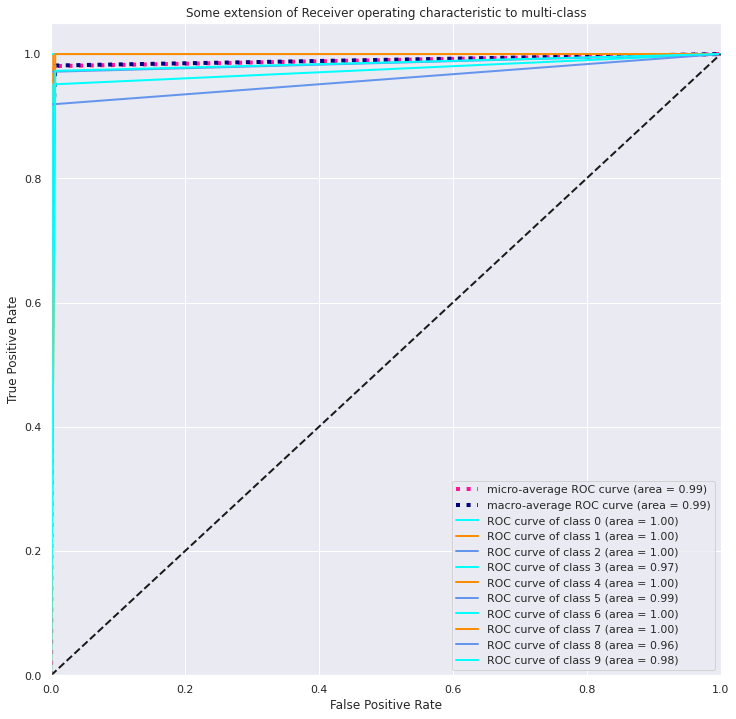

In [73]:

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])


mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(12,12))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


Del gráfico 1 podemos ver que la linea de training score es igual a 1 ya que el modelo guarda  todo el train set y luego al ocuparlo para predecir como ya entreno con este ya tiene su cluster
Del gráfico 2 se puede ver que casi todas las clases son perfectas.

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


**Selección de atributos**


In [74]:
print(digits["c00"].unique())
print(digits["c32"].unique())
print(digits["c39"].unique())

[0]
[0]
[0]


In [75]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


x_training = digits.drop(['c00','c32','c39','target'], axis=1) #Se dropean las columnas constantes 
y_training = digits['target']

k = 20  
columnas = list(x_training.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(x_training, y_training)


In [76]:
catrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(catrib.nonzero()[0])]
digits_atributos = digits[atributos + ["target"]]
print("Las columnas seleccionadas por la prueba F son:\n",atributos)


Las columnas seleccionadas por la prueba F son:
 ['c02', 'c10', 'c13', 'c20', 'c21', 'c26', 'c28', 'c30', 'c33', 'c34', 'c36', 'c38', 'c42', 'c43', 'c44', 'c46', 'c54', 'c58', 'c60', 'c61']


In [77]:
dfs_size = [digits.size,digits_atributos.size]
print("digits Original tenía", dfs_size[0], "elementos")
print("digits_atributos tiene", dfs_size[1], "elementos")

digits Original tenía 116805 elementos
digits_atributos tiene 37737 elementos


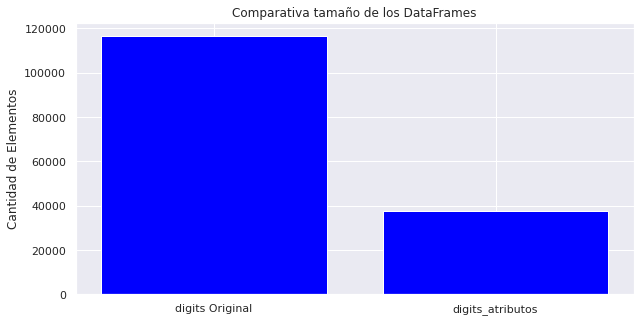

In [79]:
fig = plt.figure(figsize=(10,5))
plt.bar(x =["digits Original", "digits_atributos"], height = dfs_size, color = "Blue" )
plt.title("Comparativa tamaño de los DataFrames")
plt.ylabel("Cantidad de Elementos")
plt.show()

In [80]:
total2 = 0
memoria = digits_atributos.memory_usage() 
for i in range(0,len(memoria)):
    total2 += memoria[i]
print("El DataFrame digits_atributos usa un total de:",total2, 'bytes') 
print('En comparación el DataFrame original usaba un total de:', total, 'bytes')


El DataFrame digits_atributos usa un total de: 302024 bytes
En comparación el DataFrame original usaba un total de: 934568 bytes


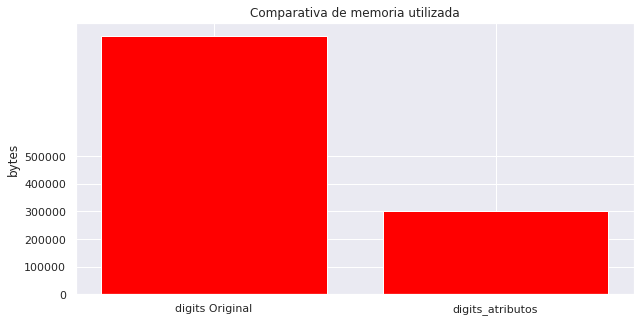

In [82]:
lista = [1e5 * i for i in range(6)]
fig = plt.figure(figsize=(10,5))
plt.bar(x = ["digits Original", "digits_atributos"], height = [total,total2],color = "red")
plt.yticks(lista)
plt.title("Comparativa de memoria utilizada")
plt.ylabel("bytes")
plt.show()


In [83]:
X = digits.drop("target",axis = 1)
y = digits["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    train_size=0.80,
                                                    random_state=1998)
start_time = time.time()
clfsvm.fit(X_train, y_train)

time_original = time.time() - start_time
print(" El modelo se ejecutó en %s segundos con el DataFrame Original" % (time_original)) 


 El modelo se ejecutó en 0.07319116592407227 segundos con el DataFrame Original


In [84]:
X = digits_atributos.drop("target",axis=1)
y = digits["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    train_size=0.70,
                                                    random_state=1998)
start_time = time.time()
clfsvm.fit(X_train, y_train)
# Se presenta el tiempo en que se ejecutó el modelo 
time_atributos = time.time() - start_time
print(" El modelo se ejecutó en %s segundos con el DataFrame digits_atributos" % (time_atributos)) 

 El modelo se ejecutó en 0.07780790328979492 segundos con el DataFrame digits_atributos


**PCA**

In [85]:
from sklearn.preprocessing import StandardScaler

#Se estandarizan los datos 
x = digits.drop("target",axis =1).values
y = digits["target"].values

x = StandardScaler().fit_transform(x)


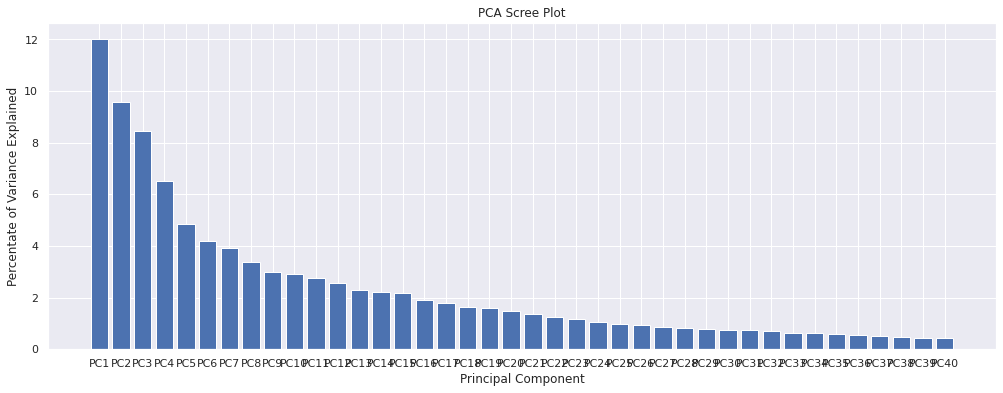

In [86]:
# Se ajusta el modelo 
from sklearn.decomposition import PCA
n_components = 40
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x)

percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = [f"PC{i}" for i in range(1,n_components+1)]

plt.figure(figsize=(17,6))
plt.bar(x= range(1,n_components+1), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()


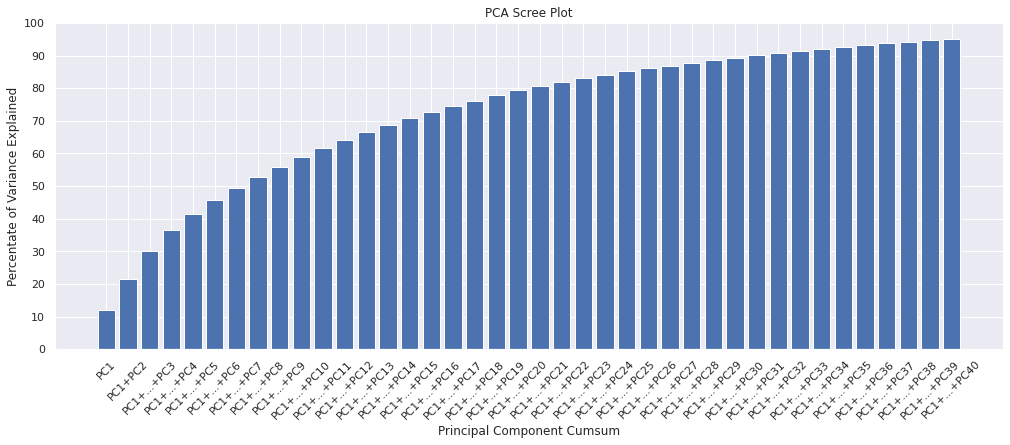

In [87]:
# graficar varianza por la suma acumulada de los componente
percent_variance_cum = np.cumsum(percent_variance)
columns_sum =[f"PC1+...+PC{i+1}" for i in range(2,n_components)]
columns_sum = ["PC1", "PC1+PC2"] + columns_sum

plt.figure(figsize=(17,6))
plt.bar(x= range(1,n_components+1), height=percent_variance_cum, tick_label=columns_sum)
plt.ylabel('Percentate of Variance Explained')
plt.yticks([10*i for i in range(11)])
plt.xlabel('Principal Component Cumsum')
plt.xticks(rotation =45)
plt.title('PCA Scree Plot')
plt.show()


In [88]:
principalDataframe = pd.DataFrame(data = principalComponents, columns = columns)
targetDataframe = digits[['target']]

digits_pca = pd.concat([principalDataframe, targetDataframe],axis = 1)
digits_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,target
0,1.914214,-0.954502,-3.946035,2.028723,-0.267174,0.530323,-1.415320,1.496065,0.124903,-0.822255,...,-0.013903,0.053185,0.019752,0.124098,0.716815,0.077751,0.843779,0.015055,0.316646,0
1,0.588980,0.924636,3.924755,-1.779850,-0.993431,-0.675644,1.878561,0.556334,1.079905,0.087479,...,-1.144140,0.039169,0.367331,-0.687152,-0.000168,-0.268753,0.209867,0.099926,-0.485145,1
2,1.302039,-0.317189,3.023333,-2.043377,-2.081153,0.935114,-1.296197,1.156164,0.785565,-1.099240,...,0.498164,-1.351402,-0.100189,0.183973,-0.079078,0.434257,-0.208699,-1.276273,0.485266,2
3,-3.020770,-0.868772,-0.801744,-2.187039,-0.556814,0.727129,0.959762,-1.382638,0.259091,0.744572,...,0.873526,0.121079,-0.477787,-0.172452,0.240549,0.374473,0.209832,0.794543,-0.014500,3
4,4.528949,-1.093480,0.973120,-1.419509,-1.715109,1.431609,1.073641,-0.968251,-1.660156,1.174662,...,-0.371822,0.266914,0.487109,-0.315214,-0.585469,-0.216895,-0.237105,-0.123077,0.265478,4


In [89]:
dfs_pca_size = [digits.size,digits_pca.size]
print("digits Original tenía", dfs_pca_size[0], "elementos")
print("digits_atributos tiene", dfs_pca_size[1], "elementos")

digits Original tenía 116805 elementos
digits_atributos tiene 73677 elementos


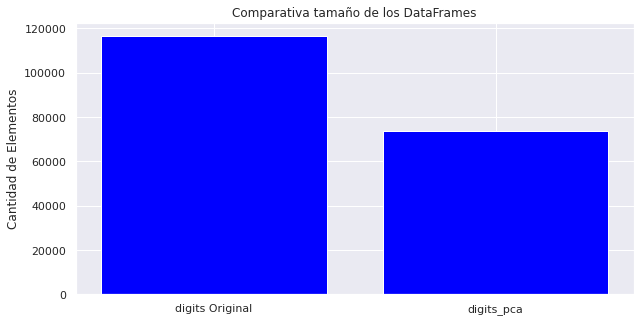

In [91]:
fig = plt.figure(figsize=(10,5))
plt.bar(x =["digits Original", "digits_pca"], height = dfs_pca_size, color = 'blue' )
plt.title("Comparativa tamaño de los DataFrames")
plt.ylabel("Cantidad de Elementos")
plt.show()


In [92]:
total3 = 0
memoria = digits_pca.memory_usage()  
for i in range(0,len(memoria)):
    total3 += memoria[i]
print("El DataFrame digits_pca usa un total de:",total2, 'bytes') 
print('En comparación el DataFrame original usaba un total de:', total, 'bytes')

El DataFrame digits_pca usa un total de: 302024 bytes
En comparación el DataFrame original usaba un total de: 934568 bytes


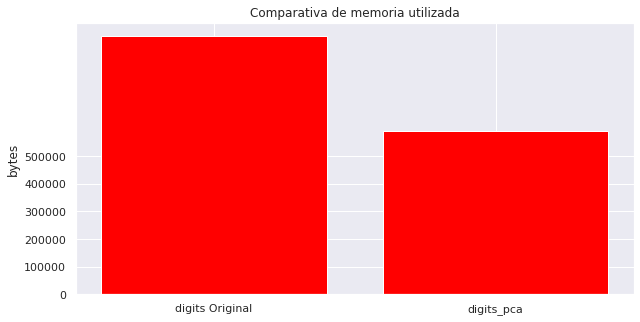

In [94]:
lista = [1e5 * i for i in range(6)]
fig = plt.figure(figsize=(10,5))
plt.bar(x = ["digits Original", "digits_pca"], height = [total,total3],color = "red")
plt.yticks(lista)
plt.title("Comparativa de memoria utilizada")
plt.ylabel("bytes")
plt.show()


In [95]:
X = digits.drop("target",axis = 1)
y = digits["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    train_size=0.70,
                                                    random_state=1998)
start_time = time.time()
clfsvm.fit(X_train, y_train)

time_original = time.time() - start_time
print(" El modelo se ejecutó en %s segundos con el DataFrame Original" % (time_original)) 


 El modelo se ejecutó en 0.0598750114440918 segundos con el DataFrame Original


In [96]:
X = digits_pca.drop("target",axis=1)
y = digits["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    train_size=0.70,
                                                    random_state=1998)
start_time = time.time()
clfsvm.fit(X_train, y_train)
# Se presenta el tiempo en que se ejecutó el modelo 
time_pca = time.time() - start_time
print(" El modelo se ejecutó en %s segundos con el DataFrame digits_pca" % (time_pca)) 

 El modelo se ejecutó en 0.0683889389038086 segundos con el DataFrame digits_pca


### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [108]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    Y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == Y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != Y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = np.array(Y_test)[mask]
    y_aux_pred = np.array(y_pred)[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

In [101]:
modelo = SVC(kernel= 'rbf', C=7) 


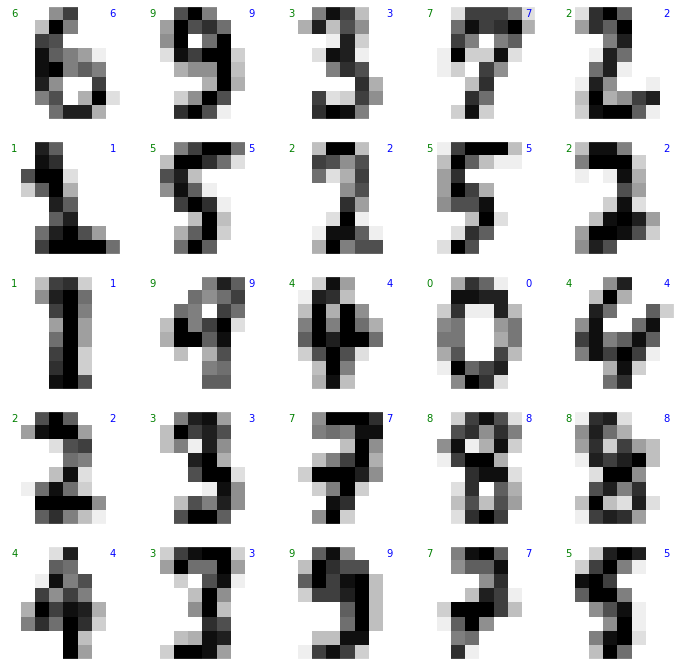

In [109]:
mostar_resultados(digits,modelo,nx=5, ny=5,label = "correctos")

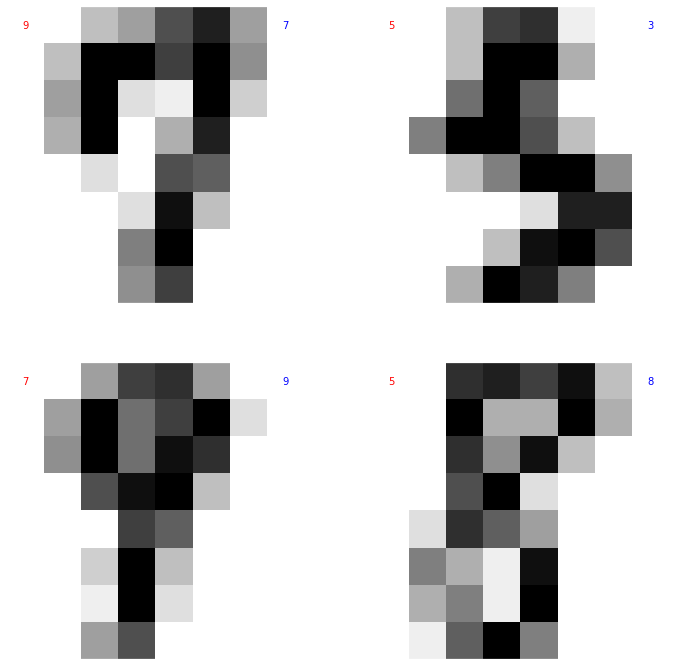

In [110]:
mostar_resultados(digits,modelo,nx=2, ny=2,label = "incorrectos")

Deben ser por que son puntos muy cercanos a la frontera de decisión de SVM, lo cual provoca que el hiperplano no tenga tanta seguridad al clasificarlos.

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

In [30]:
# read data
housing = pd.read_csv('data/housing.csv',sep=',')
housing.head()

FileNotFoundError: ignored

In [ ]:
## FIX ME PLEASE